# Importando librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Cargamos el dataset: Fashion MNIST

In [ ]:
# Transformaciones
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Carga de los datos
train_dataset = torchvision.datasets.FashionMNIST(root='/data/FashionMNIST', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='/data/FashionMNIST', train=False, transform=transform, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 17254245.62it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 320549.36it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5588855.61it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14337501.32it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



In [ ]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [ ]:
print(f"Número total de clases: {len(train_dataset.targets.unique())}")

Número total de clases: 10


In [ ]:
train_dataset.data.size()

torch.Size([60000, 28, 28])

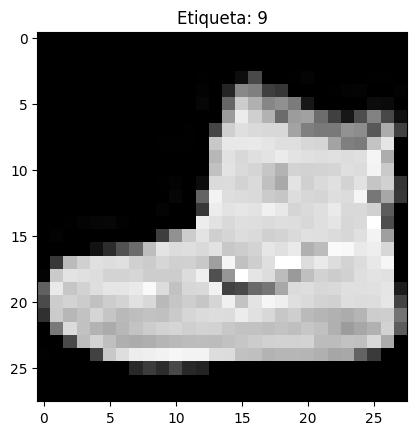

In [ ]:
train_data = train_dataset.data
train_labels = train_dataset.targets

ejemplo_img_train = train_data[0]
ejemplo_label_train = train_labels[0]

plt.imshow(ejemplo_img_train, cmap='gray')
plt.title(f'Etiqueta: {ejemplo_label_train}')
plt.show()

# Arquitecturas CGAN

## Generador (G)

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_dim=100, out_dim=28*28, class_num=10):
    super(Generator, self).__init__()
    self.input_dim = input_dim
    self.label_emb = nn.Embedding(class_num, class_num)

    self.fc1 = nn.Sequential(nn.Linear(input_dim + class_num, 256),
                             nn.LeakyReLU(0.2, inplace=True))
    self.fc2 = nn.Sequential(nn.Linear(256, 512),
                             nn.LeakyReLU(0.2, inplace=True))

    # Parte intermedia
    self.ib = nn.Sequential(nn.Linear(512, 512),
                            nn.LeakyReLU(0.2, inplace=True))

    self.fc3 = nn.Sequential(nn.Linear(512, 1024),
                             nn.LeakyReLU(0.2, inplace=True))
    self.fc4 = nn.Sequential(nn.Linear(1024, out_dim),
                             nn.Tanh())

  def forward(self, x, labels):
    x = x.view(-1, self.input_dim)
    o_hot = self.label_emb(labels)
    x = torch.cat([x, o_hot], dim=1)
    x = self.fc1(x)
    x = self.fc2(x)

    x = self.ib(x)

    x = self.fc3(x)
    x = self.fc4(x)
    x = x.view(-1, 28, 28) #
    return x

## Discriminador (D)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_dim=28*28, class_num=10):
    super(Discriminator, self).__init__()
    self.input_dim = input_dim
    self.label_emb = nn.Embedding(class_num, class_num)
    self.fc1 = nn.Sequential(nn.Linear(input_dim + class_num, 1024),
                            nn.LeakyReLU(0.2, inplace=True),
                             nn.Dropout(0.4))
    self.fc2 = nn.Sequential(nn.Linear(1024, 512),
                            nn.LeakyReLU(0.2, inplace=True),
                             nn.Dropout(0.34))
    self.fc3 = nn.Sequential(nn.Linear(512, 256),
                            nn.LeakyReLU(0.2, inplace=True),
                             nn.Dropout(0.4))
    self.fc4 = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, labels):
    x = x.view(-1, self.input_dim)
    o_hot = self.label_emb(labels)
    x = torch.cat([x, o_hot], 1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    x = self.sigmoid(x)
    return x.squeeze()

# Definimos parámetros y configuraciones para el modelo

In [ ]:
# Parámetros
batch_size = 64
learning_rate = 1e-4
epochs = 30
z_size = 100
class_num = len(train_dataset.targets.unique())
images_size = train_dataset.data.size()[-1] * train_dataset.data.size()[-1]

# Instanciamos modelos
generator = Generator(input_dim=z_size,
                      class_num=class_num).to(device)
discriminator = Discriminator(input_dim=images_size,
                              class_num=class_num).to(device)

# Definimos función de costo y optimizadores
criterion = nn.MSELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Definimos set de entrenamiento y de prueba
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Entrenamiento del modelo CGAN

Época: 1
G_loss: 0.8216198682785034, D_loss: 0.030235622078180313


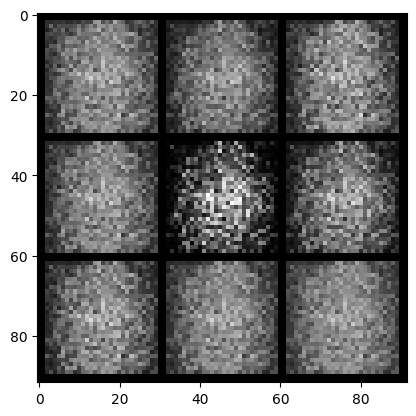



Época: 2
G_loss: 0.8025795817375183, D_loss: 0.1347281038761139


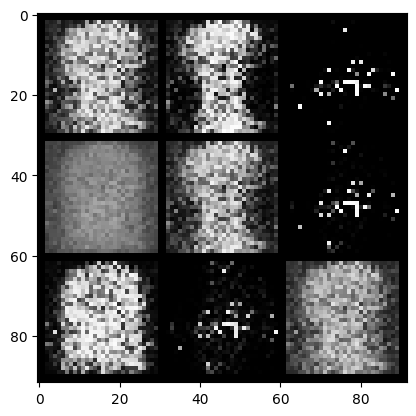



Época: 3
G_loss: 0.8564794063568115, D_loss: 0.05493773892521858


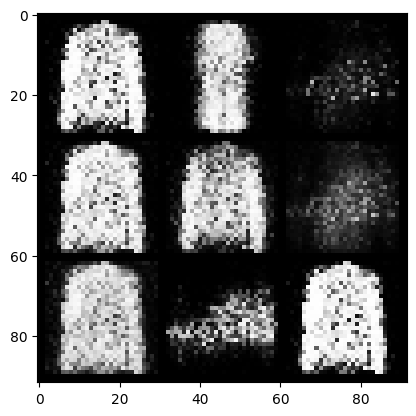



Época: 4
G_loss: 0.8185549974441528, D_loss: 0.06264229118824005


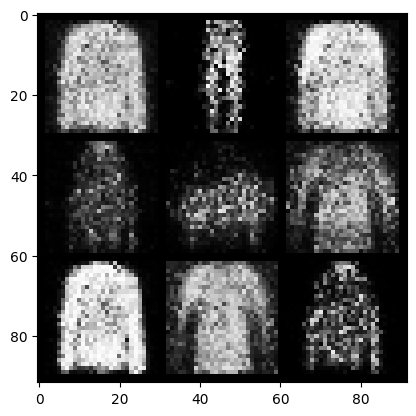



Época: 5
G_loss: 0.6752862334251404, D_loss: 0.1055978536605835


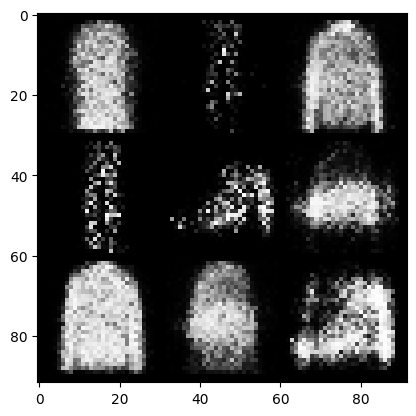



Época: 6
G_loss: 0.7257422208786011, D_loss: 0.16031073033809662


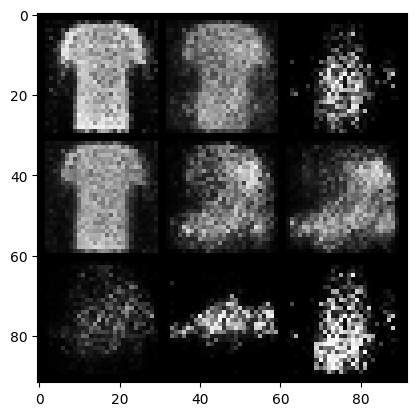



Época: 7
G_loss: 0.5535780787467957, D_loss: 0.15464158356189728


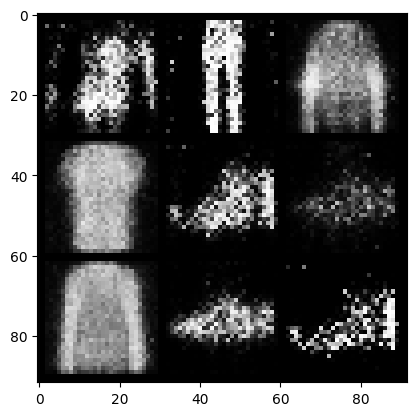



Época: 8
G_loss: 0.681037187576294, D_loss: 0.21793989837169647


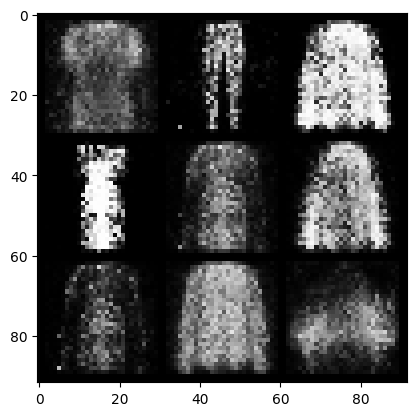



Época: 9
G_loss: 0.4853177070617676, D_loss: 0.13334541022777557


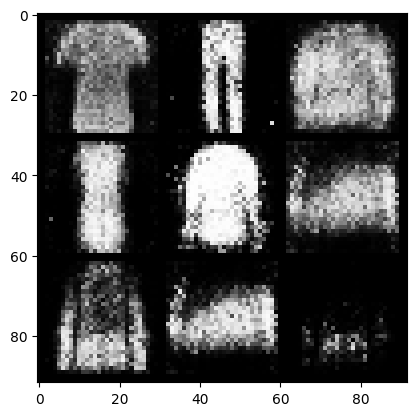



Época: 10
G_loss: 0.4671456217765808, D_loss: 0.15479739010334015


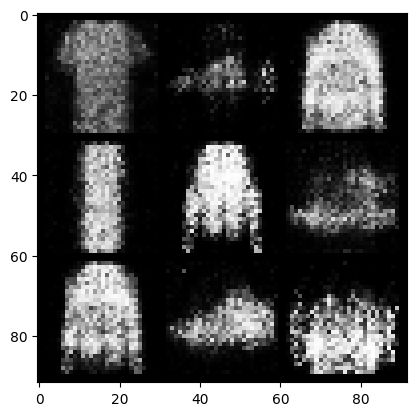



Época: 11
G_loss: 0.5518069267272949, D_loss: 0.1914457082748413


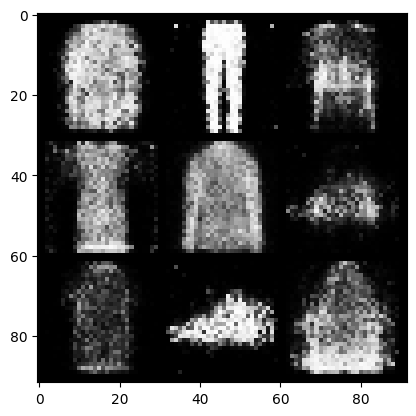



Época: 12
G_loss: 0.5587205290794373, D_loss: 0.13261154294013977


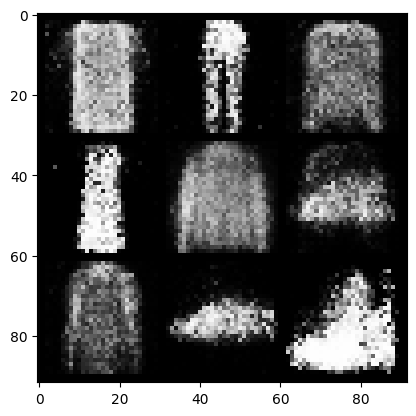



Época: 13
G_loss: 0.5159804224967957, D_loss: 0.13332965970039368


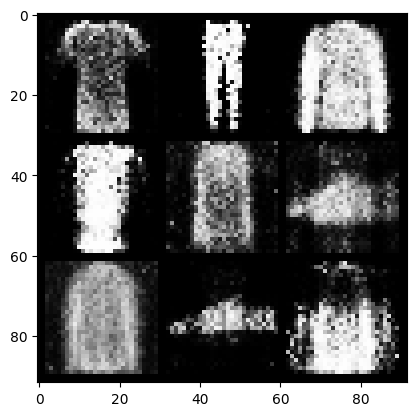



Época: 14
G_loss: 0.409214586019516, D_loss: 0.1804662048816681


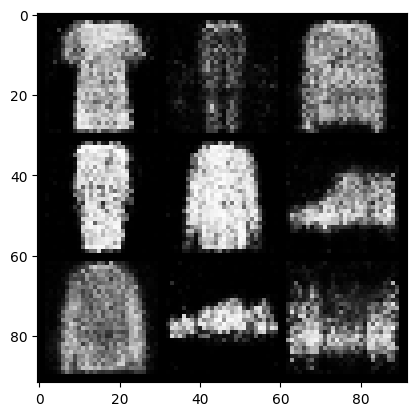



Época: 15
G_loss: 0.5277805328369141, D_loss: 0.17628304660320282


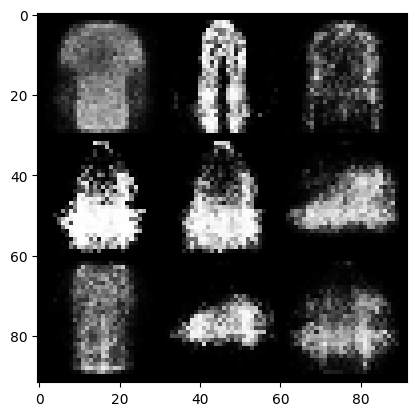



Época: 16
G_loss: 0.5636297464370728, D_loss: 0.1649579405784607


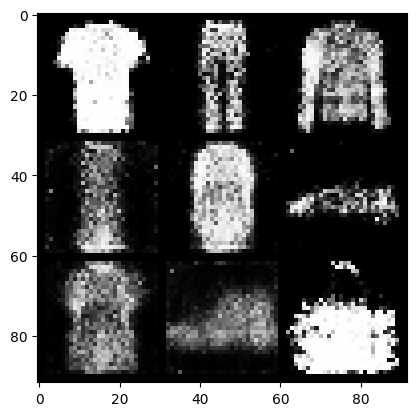



Época: 17
G_loss: 0.6101726293563843, D_loss: 0.14047479629516602


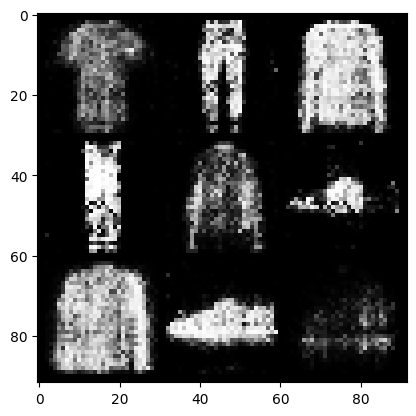



Época: 18
G_loss: 0.4752957820892334, D_loss: 0.15650905668735504


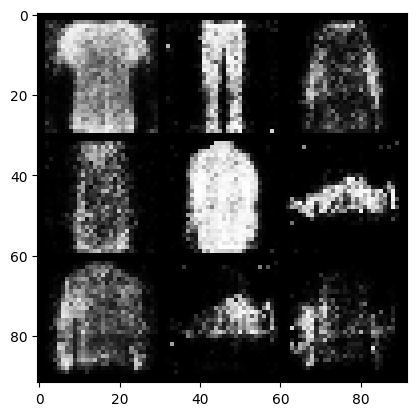



Época: 19
G_loss: 0.4234600067138672, D_loss: 0.1738845407962799


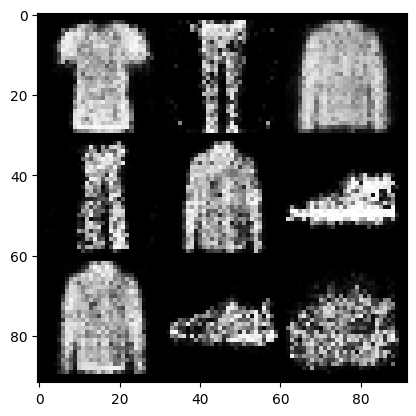



Época: 20
G_loss: 0.4460092782974243, D_loss: 0.2451612949371338


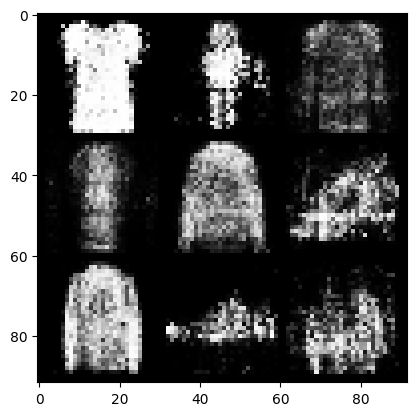



Época: 21
G_loss: 0.4454940855503082, D_loss: 0.16588911414146423


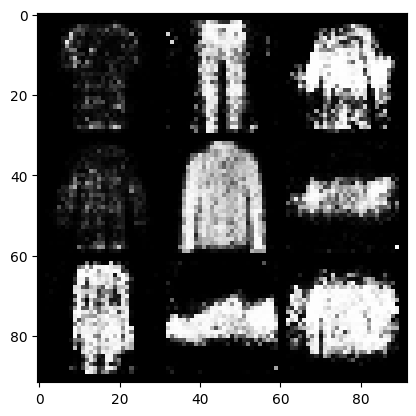



Época: 22
G_loss: 0.4475390315055847, D_loss: 0.15803922712802887


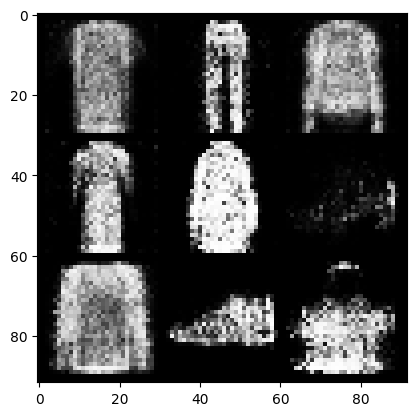



Época: 23
G_loss: 0.42606979608535767, D_loss: 0.17290139198303223


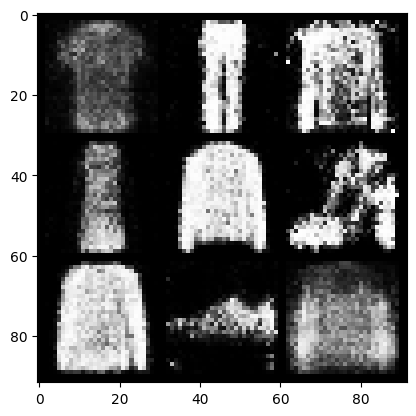



Época: 24
G_loss: 0.47230613231658936, D_loss: 0.16115343570709229


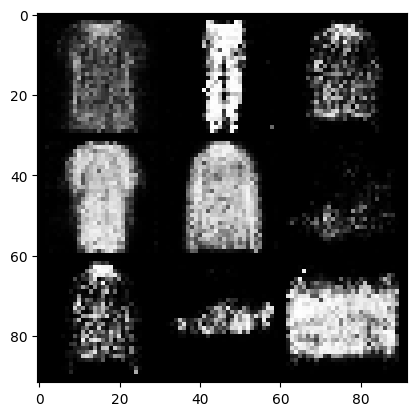



Época: 25
G_loss: 0.34886205196380615, D_loss: 0.21561869978904724


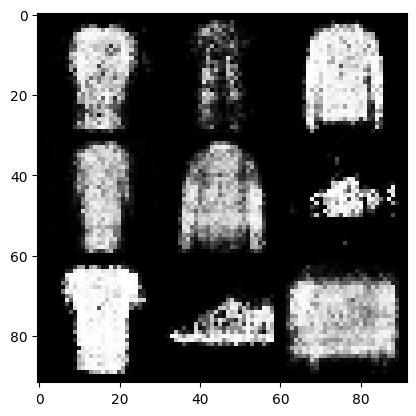



Época: 26
G_loss: 0.41886648535728455, D_loss: 0.1625061333179474


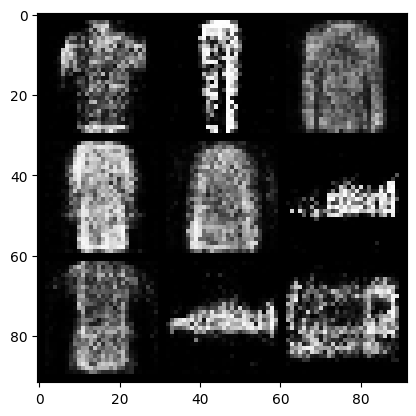



Época: 27
G_loss: 0.3750091791152954, D_loss: 0.2560340166091919


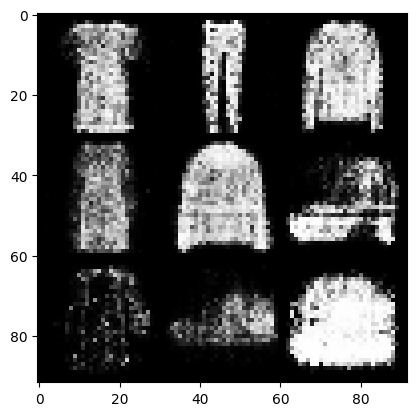



Época: 28
G_loss: 0.34092769026756287, D_loss: 0.19461458921432495


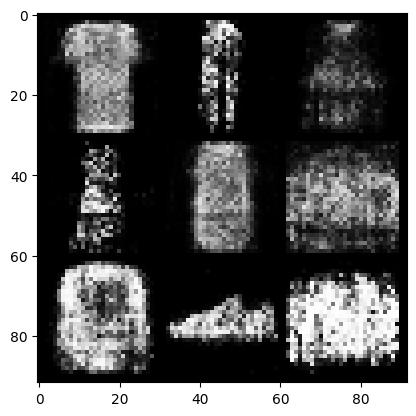



Época: 29
G_loss: 0.41225242614746094, D_loss: 0.2192220389842987


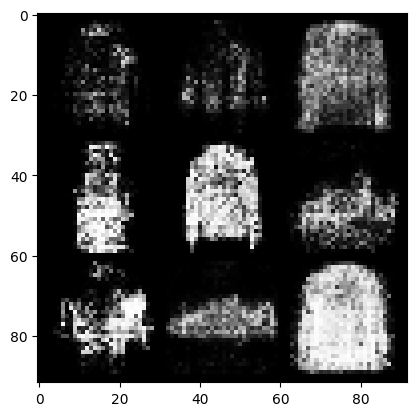



Época: 30
G_loss: 0.411726176738739, D_loss: 0.1826358437538147


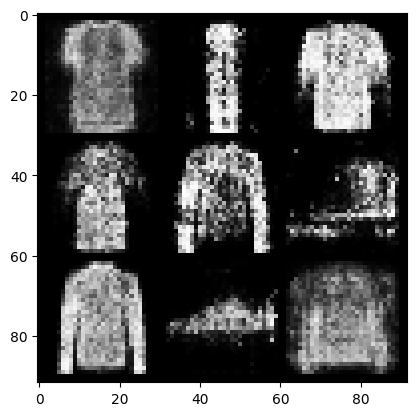

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(epochs):
  print(f"Época: {epoch + 1}")

  for i, (images, labels) in enumerate(train_loader):
    batch_size = images.shape[0]

    # Definimos tensores de 1s y 0s
    valid = Variable(torch.ones(batch_size)).to(device)
    fake = Variable(torch.zeros(batch_size)).to(device)

    # Definimos nuestras imagenes reales y labels reales
    real_images = Variable(images).to(device)
    labels = Variable(labels).to(device)

    # Ruido gaussiano
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Seteamos el generador en modo de entrenamiento
    generator.train()

    # ---------------------------------
    #  Entrenamiento del discriminador
    # ---------------------------------

    optimizer_D.zero_grad()

    # Calculamos la funciones de pérdida para imagenes reales
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, valid)

    # Generamos batch de imagenes y labels
    gen_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    gen_images = generator(z, gen_labels)

    # Calculamos la funciones de pérdida para imagenes falsas
    fake_validity = discriminator(gen_images, gen_labels)
    fake_loss = criterion(fake_validity, fake)

    # Se suma las loss y promediamos
    d_loss = (real_loss + fake_loss) * 0.5

    d_loss.backward()
    optimizer_D.step()

    # -----------------------------
    #  Entrenamiento del generador
    # -----------------------------

    optimizer_G.zero_grad()

    # Generamos imagenes falsas
    gen_images = generator(z, gen_labels)
    validity = discriminator(gen_images, gen_labels)

    # Calculamos la función de pérdida de la discrepancia
    g_loss = criterion(validity, valid)

    g_loss.backward()
    optimizer_G.step()

  # Seteamos el modelo en modo de evaluación
  generator.eval()

  print('G_loss: {}, D_loss: {}'.format(g_loss.item(), d_loss.item()))

  # Instanciamos un ruido gaussiano
  z = Variable(torch.randn(class_num-1, z_size)).to(device)

  # Generamos labels entre las clases 0 y 8
  labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)

  # Generamos imagenes
  sample_images = generator(z, labels).unsqueeze(1).data.cpu()

  # Se grafican las imagenes
  grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
  plt.imshow(grid)
  plt.show()
  print(f"\n")

# Guardar modelo

In [ ]:
def save_model(name):
  save_path = f"/models/{name}.pt"
  torch.save(generator.state_dict(), save_path)
  print(f'Modelo guardado en {save_path}')

In [ ]:
save_model('generatorEncDec_clothes_28p')

# Carga del modelo


Para cargar los modelos, en necesario que ejecute la celda del modelo generador a ocupar.

In [ ]:
def load_model(generator_model, path_model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  if device == 'cuda':
    checkpoint = torch.load(path_model)
    generator_model.load_state_dict(checkpoint)
  else:
    checkpoint = torch.load(path_model, map_location=torch.device('cpu'))
    generator_model.load_state_dict(checkpoint)
  return generator_model

In [ ]:
model = Generator(input_dim=100,
                  class_num=6).to(device)
ruta = "/models/generatorEncDec_clothes_28p.pt"

generator = load_model(model, ruta)

# Sampleo

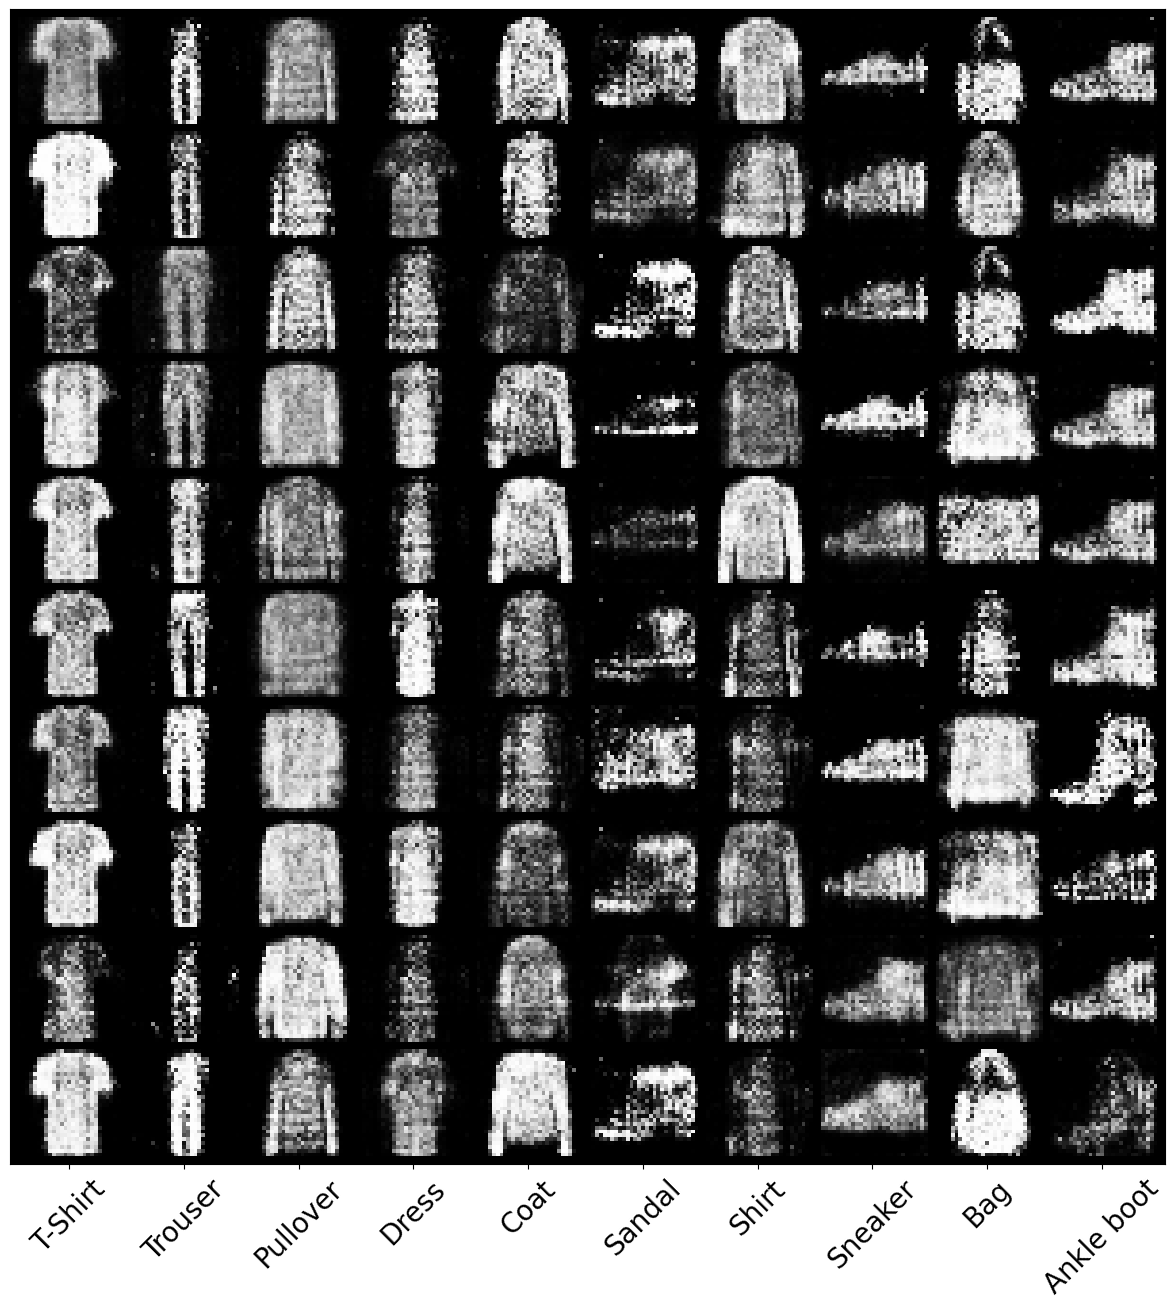

In [ ]:
z_size = 100
class_num = 6

# Nombre de las clases
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Instanciamos ruido gaussiano
z = Variable(torch.randn(z_size, z_size)).to(device)

# Generamos labels
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generamos imagenes
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Graficamos imagenes
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)